# Set up Workspace

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
from scipy.stats import ttest_ind
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from eofs.xarray import Eof 

In [2]:
import cftime
import scipy

In [3]:
import sys
sys.path.append('/glade/u/home/czarakas/coupled_PPE/code/utils')

import make_multisimulation_dataset

In [4]:
from load_ensembles import *
import quick_map

In [5]:
import make_multisimulation_dataset

# Load data

In [9]:
var_array_PRECT=xr.open_dataset('data/PRECT_delta_Annual.nc')['__xarray_dataarray_variable__']

In [23]:
from load_gridcell_areas import *

# Do EOF analysis

In [24]:
var_array=var_array_PRECT

In [28]:
deltaT=(var_array-var_array.mean(dim='ensemble_key'))
#deltaT_global=(deltaT*landweights).mean(dim=['lat','lon'])
#deltaT_normalized=deltaT#-deltaT_global

In [29]:
ds_eofs=deltaT

In [30]:
from datetime import datetime, timedelta
num_ensembles=np.shape(ds_eofs)[2]
print(num_ensembles)
date2=datetime(2000,1,1)+timedelta(days=num_ensembles, minutes=0)
date2_str=date2.isoformat()[0:10]

36


In [31]:
# Rearrange all-model dataset for EOF
ds_eofs=ds_eofs.transpose()
ds_eofs=ds_eofs.rename({"ensemble_key": "time"})
ds_eofs['time']=np.arange('2000-01-01', date2_str, dtype='datetime64') #11
ds_eofs=ds_eofs-ds_eofs.mean(dim='time')

In [32]:
#solver = Eof(ds_eofs, weights=areaweights.transpose())
solver = Eof(ds_eofs, weights=landweights.transpose())
eofs = solver.eofs()
eofs = eofs.transpose()
pcs = solver.pcs()#pcscaling=2)

# Analyze EOF output

#### Fraction of variance explained

In [35]:
var='PRECT'

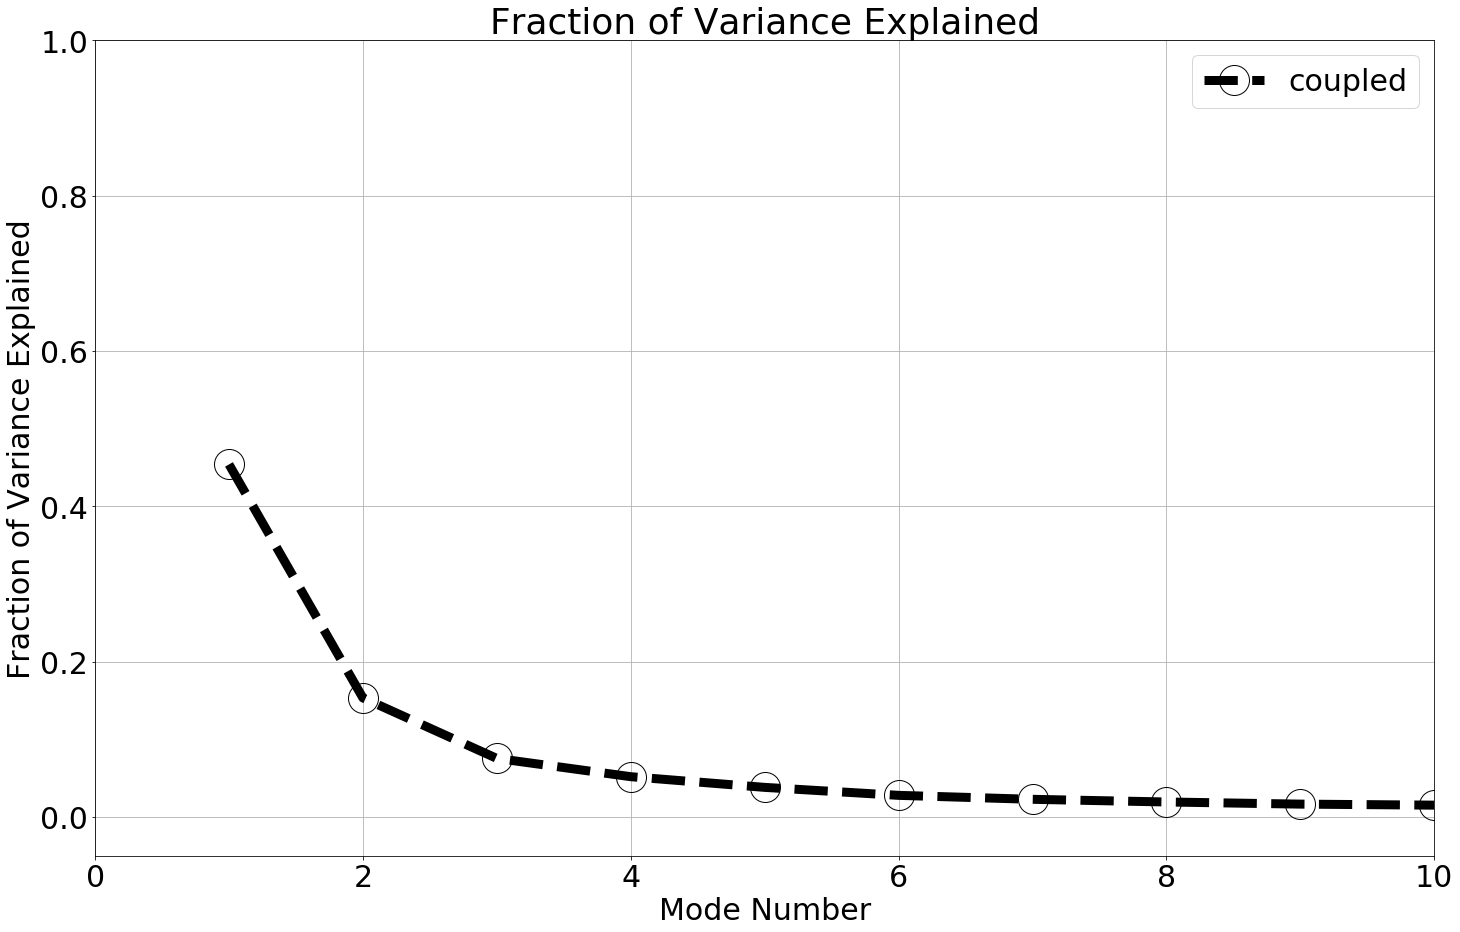

In [36]:
plt.rcParams.update({'font.size': 30})
fig = plt.figure(figsize=(24,15))
plt.plot(np.arange(1,np.size(ds_eofs['time'])+1),solver.varianceFraction().values,
         'o--k', fillstyle='none',markersize=30,linewidth=9, label='coupled')
solver.varianceFraction().values[0]+solver.varianceFraction().values[1]
plt.xlim([0,10])
plt.ylim([-0.05,1])
plt.title('Fraction of Variance Explained')
plt.xlabel('Mode Number')
plt.ylabel('Fraction of Variance Explained')
plt.grid()
plt.legend()
plt.savefig(var+'_frac_variance_explained.png')

In [37]:
for i in np.arange(0,4):
    print('EOF '+str(i+1))
    print(solver.varianceFraction().values[i])
    print(solver.varianceFraction().values[0:i+1].sum())

EOF 1
0.4539770458068044
0.4539770458068044
EOF 2
0.1533174839018187
0.6072945297086232
EOF 3
0.07538886548788049
0.6826833951965037
EOF 4
0.05187099403940462
0.7345543892359083


### Check reconstruction

This shows that to reconstructed signal you sum up (EOFS * PCs / landweights) across all the principal components

In [40]:
plt.rcParams.update({'font.size': 14})

In [41]:
reconstructed=solver.reconstructedField(3)
reconstructed_T=reconstructed.transpose()

reconstructed_mode0=eofs[:,:,0]*pcs[:,0]/landweights
reconstructed_mode1=eofs[:,:,1]*pcs[:,1]/landweights
reconstructed_mode2=eofs[:,:,2]*pcs[:,2]/landweights
reconstructed_manual=reconstructed_mode0+reconstructed_mode1+reconstructed_mode2

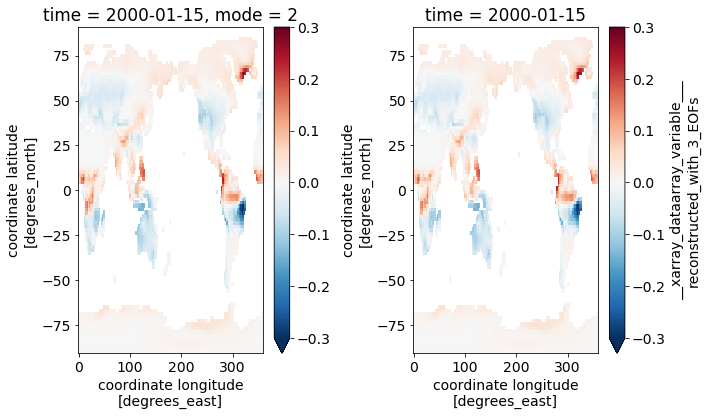

In [62]:
i=14
vmax=0.3
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
(reconstructed_manual)[:,:,i].plot(vmax=vmax)
plt.subplot(1,2,2)
(reconstructed_T)[:,:,i].plot(vmax=vmax)
plt.tight_layout()

### Patterns

In [66]:
scaling_factor_eof0=1/(eofs[:,:,0]).mean(dim=['lat','lon'])
((eofs[:,:,0]*scaling_factor_eof0/landweights)*landweights).mean(dim=['lat','lon'])

<xarray.DataArray ()>
array(1.)
Coordinates:
    mode     int64 0

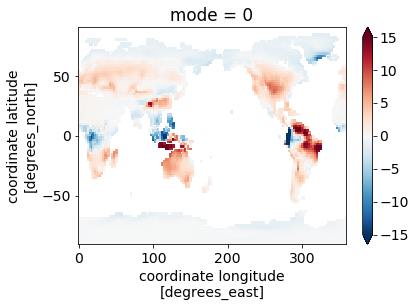

In [69]:
(eofs[:,:,0]*scaling_factor_eof0/landweights).plot(vmax=15)

### PCs